In [1]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-1ssvvy2j
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-1ssvvy2j
  Resolved https://github.com/huggingface/transformers.git to commit ca03842cdcf2823301171ab27aec4b6b1cafdbc1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

In [3]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

(…)-00000-of-00001-fc7c825a21687306.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

In [4]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

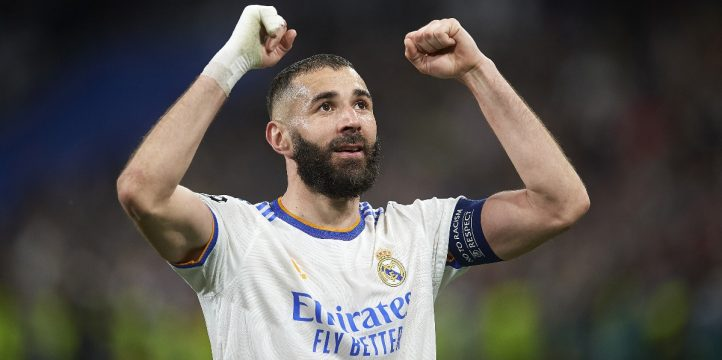

In [5]:
dataset[0]["image"]

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [7]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [8]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## traning

In [9]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.980634689331055
Loss: 10.295759201049805
Loss: 10.187945365905762
Epoch: 1
Loss: 10.175997734069824
Loss: 10.158690452575684
Loss: 10.169553756713867
Epoch: 2
Loss: 10.114301681518555
Loss: 10.148094177246094
Loss: 10.080211639404297
Epoch: 3
Loss: 10.097536087036133
Loss: 10.093894004821777
Loss: 10.02729320526123
Epoch: 4
Loss: 10.046926498413086
Loss: 10.074246406555176
Loss: 9.980116844177246
Epoch: 5
Loss: 9.964139938354492
Loss: 9.988404273986816
Loss: 9.963860511779785
Epoch: 6
Loss: 9.903227806091309
Loss: 9.550918579101562
Loss: 9.265410423278809
Epoch: 7
Loss: 8.85123348236084
Loss: 8.593307495117188
Loss: 8.315451622009277
Epoch: 8
Loss: 8.082521438598633
Loss: 7.8526930809021
Loss: 7.609921932220459
Epoch: 9
Loss: 7.4237871170043945
Loss: 7.1873273849487305
Loss: 7.018274307250977
Epoch: 10
Loss: 6.819398880004883
Loss: 6.691042900085449
Loss: 6.520265579223633
Epoch: 11
Loss: 6.324565410614014
Loss: 6.19771146774292
Loss: 6.032854080200195
Epoch: 12
Loss: 5.864111

## Save model on huggingface

In [19]:
model.save_pretrained("blip-model")
processor.save_pretrained("blip-model")

[]

In [28]:
!pip install transformers huggingface_hub

In [13]:
from huggingface_hub import notebook_login
notebook_login()

In [34]:
model.push_to_hub("osmanh/blip-model-finetuned")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osmanh/blip-model-finetuned/commit/52461d7ddbb69b64ad0ed89c2eba7996baacb98a', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='52461d7ddbb69b64ad0ed89c2eba7996baacb98a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/blip-model-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/blip-model-finetuned'), pr_revision=None, pr_num=None)

In [35]:
processor.push_to_hub("osmanh/blip-model-finetuned")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osmanh/blip-model-finetuned/commit/1e4f2ccf8325b730fc89f8c0799976685a3daab2', commit_message='Upload processor', commit_description='', oid='1e4f2ccf8325b730fc89f8c0799976685a3daab2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/blip-model-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/blip-model-finetuned'), pr_revision=None, pr_num=None)

## prediction

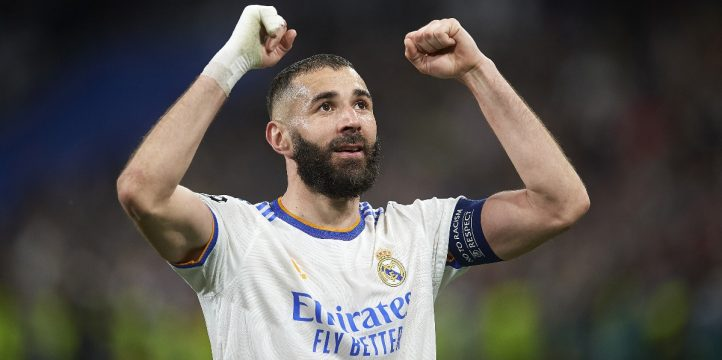

In [36]:
# load image
example = dataset[0]
image = example["image"]
image

In [37]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid ' s win against psg


In [38]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("osmanh/blip-model-finetuned").to(device)
processor = AutoProcessor.from_pretrained("osmanh/blip-model-finetuned")

config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

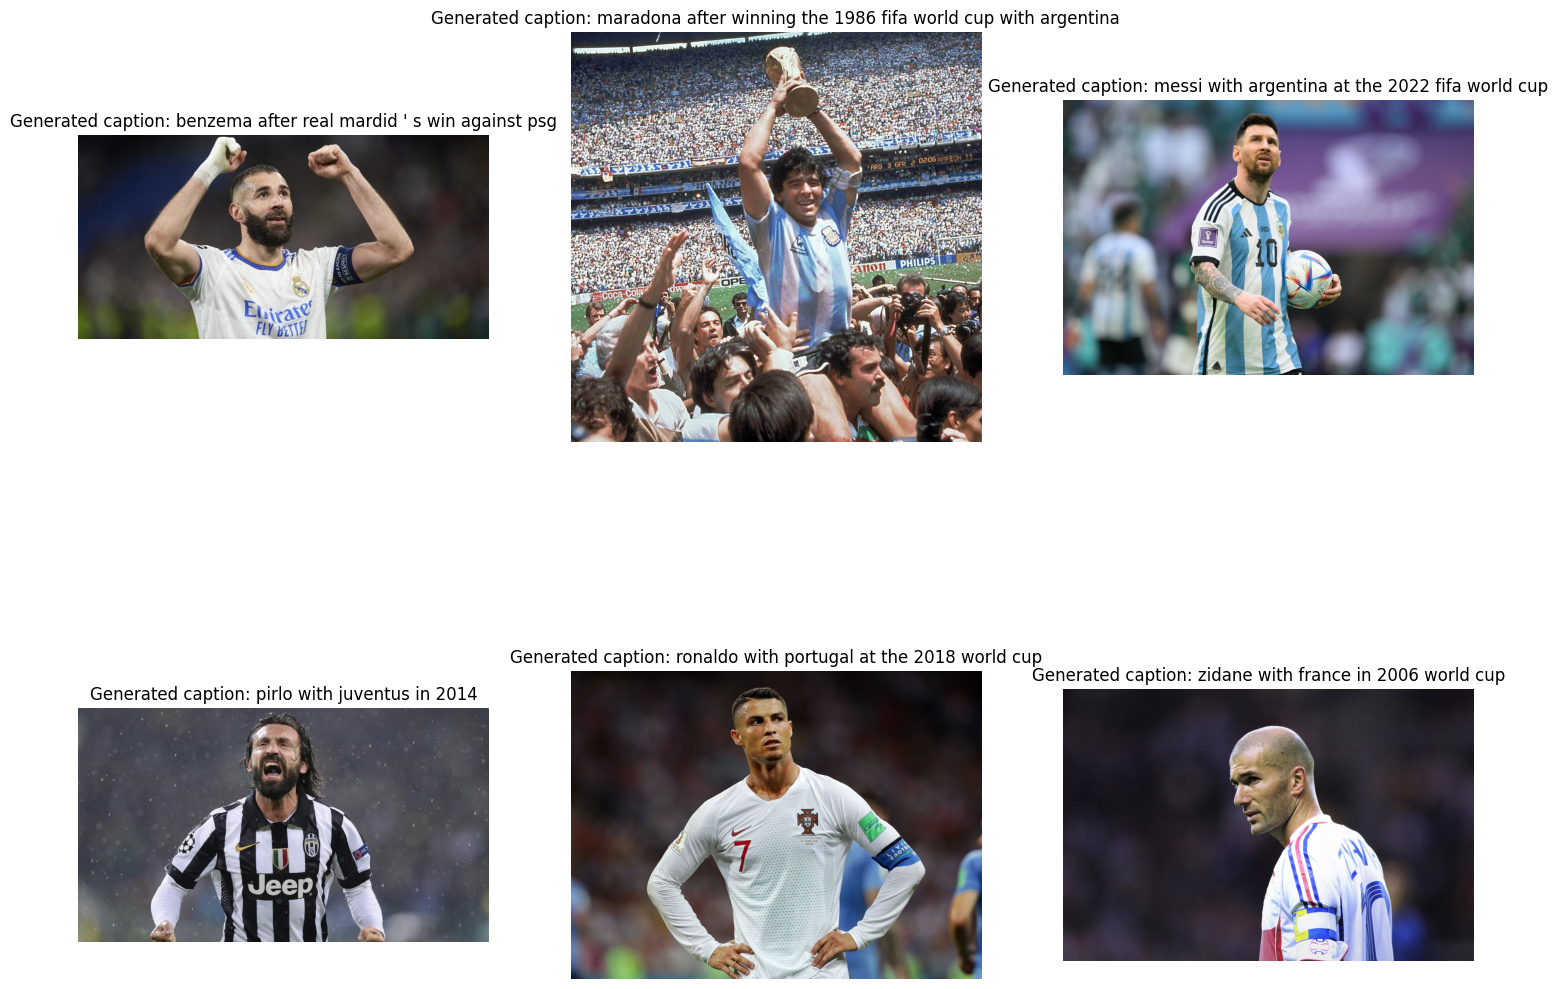

In [39]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")